In [127]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from dataclasses import dataclass
from typing import Any, List, Tuple, Dict
from pandas import DataFrame

In [3]:
@dataclass
class City:
    index : int
    X : float
    Y : float

@dataclass
class Item:
    index : int
    Profit : int
    Weight : int
    Node : int
    
@dataclass
class TTP:
    Name :str = None
    DTYPE : str = None
    Dimension : int = 0
    ITEMS : int = 0
    CAPACITY : int = 0
    MIN_SPEED : float = 0
    MAX_SPEED : float = 0
    RENTING_RATIO : float = 0
    EDGE_W : str = None
    NODE : List[City] = None
    ITEM : List[Item] = None

def read_problem(file_path:str):
    with open(file_path,'r') as file:
        lines = file.readlines()
    
    data = TTP(NODE=[],ITEM=[])
    
    for i , line in enumerate(lines):
        if line.startswith("PROBLEM NAME"):
            data.Name = line.split(':')[-1].strip()
        elif line.startswith("KNAPSACK DATA TYPE"):
            data.DTYPE = line.split(':')[-1].strip()
        elif line.startswith("DIMENSION"):
            data.Dimension = int(line.split(':')[-1].strip())
        elif line.startswith("NUMBER OF ITEMS"):
            data.ITEMS = int(line.split(':')[-1].strip())
        elif line.startswith("DIMENSION"):
            data.Dimension = int(line.split(':')[-1].strip())
        elif line.startswith("MIX SPEED"):
            data.MIN_SPEED = float(line.split(':')[-1].strip())
        elif line.startswith("MAX SPEED"):
            data.MAX_SPEED = float(line.split(':')[-1].strip())
        elif line.startswith("RENTING RATIO"):
            data.RENTING_RATIO = float(line.split(':')[-1].strip())
        elif line.startswith("EDGE_WEIGHT_TYPE"):
            data.EDGE_W = line.split(':')[-1].strip()
        elif line.startswith("NODE_COORD_SECTION"):
            for j in range(1,data.Dimension+1):
                node = lines[i+j].split()
                data.NODE.append(City(index=int(node[0]),X=float(node[1]),Y=float(node[2])))
        elif line.startswith("ITEMS SECTION"):
            for j in range(1,data.ITEMS+1):
                item = lines[i+j].split()
                data.ITEM.append(
                    Item(int(item[0]),int(item[1]),int(item[2]),int(item[3]))
                )
        else:
            pass
    
    return data.NODE , data.ITEM

def generate_ttp_solution(number_of_cities: int, items: List[Item], knapsack_capacity: int) -> Tuple[List[int], List[int]]:
    # Generate a random path (tour)
    path = np.random.permutation(number_of_cities) + 1

    # Initialize knapsack plan with no items picked
    plan = [0] * len(items)
    current_weight = 0

    # Randomly decide to pick up items considering the knapsack capacity
    for i, item in enumerate(items):
        item_weight = item.Weight
        if current_weight + item_weight <= knapsack_capacity:
            decision = np.random.choice([0, 1])
            plan[i] = decision
            current_weight += item_weight * decision

    return path.tolist(), plan

def euclidean_distance(p1: Tuple[float, float], p2: Tuple[float, float]) -> float:
    return np.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)

def calculate_time_and_profit(solution: List[int], plan: List[int], nodes: List[City], items: List[Item], min_speed, max_speed, max_weight):
    total_time = 0
    total_profit = 0
    current_weight = 0

    # Calculate the total travel time
    for i in range(len(solution)):
        current_city_index = solution[i]
        next_city_index = solution[0] if i == len(solution) - 1 else solution[i + 1]

        current_city = nodes[current_city_index - 1]
        next_city = nodes[next_city_index - 1]

        # Update current weight based on items picked at the current city
        for item, is_picked in zip(items, plan):
            if is_picked and item.Node == current_city_index:
                current_weight += item.Weight

        # Calculate speed based on current weight
        speed = max_speed - (current_weight / max_weight) * (max_speed - min_speed)
        speed = max(speed, min_speed)  # Ensure speed doesn't drop below minimum

        # Distance between current city and next city
        distance = euclidean_distance((current_city.X, current_city.Y), (next_city.X, next_city.Y))

        # Update time with time to next city
        total_time += distance / speed

        if current_weight > max_weight:
            return np.Inf , 0.0

    # Calculate total profit from picked items
    for item, is_picked in zip(items, plan):
        if is_picked:
            total_profit += item.Profit


    return total_time, total_profit

In [4]:
path = './datasets/test-example-n4.txt'
path2 = './datasets/a280-n1395.txt'
node , item = read_problem(file_path=path)
print(node,'\n', item)

[City(index=1, X=0.0, Y=0.0), City(index=2, X=4.0, Y=0.0), City(index=3, X=8.0, Y=3.0), City(index=4, X=0.0, Y=3.0)] 
 [Item(index=2, Profit=34, Weight=30, Node=2), Item(index=3, Profit=40, Weight=40, Node=3), Item(index=4, Profit=25, Weight=21, Node=4)]


In [5]:
max_weight = 80
max_speed = 1
min_speed = 0.1

path = [1,4,3,2]
plan = [1,1,0]
cost = calculate_time_and_profit(path,plan,node,item,min_speed,max_speed,max_weight)
cost

(38.91443850267379, 74)

In [6]:
renting_ratio = 1.516

# @dataclass
# class Genome:
#     path : List[int]
#     plan : List[int]

@dataclass
class Phenome:
    time : float
    profit : float
    net_profit : float = 0

    def __post_init__(self):
        self.net_profit = self.profit - (self.time*renting_ratio)

@dataclass
class Chromosome:
    path : List[int]
    plan : List[int]
    phenome : Phenome = None

    def __post_init__(self):
        self.phenome = Phenome(
            *calculate_time_and_profit(
                self.path,self.plan,node,item,min_speed,max_speed,max_weight))

@dataclass
class Population:
    population : List[Chromosome]
    


In [7]:
path,plan = generate_ttp_solution(4,item,80)

In [8]:
g1 = Chromosome(path,plan)
g1

Chromosome(path=[2, 4, 3, 1], plan=[1, 0, 0], phenome=Phenome(time=38.55698678538495, profit=34, net_profit=-24.45239196664358))

In [9]:
population_size = 10
population = [ Chromosome(*generate_ttp_solution(4,item,80)) for _ in range(population_size)]
population

[Chromosome(path=[1, 4, 3, 2], plan=[1, 0, 0], phenome=Phenome(time=22.037735849056602, profit=34, net_profit=0.5907924528301933)),
 Chromosome(path=[4, 1, 3, 2], plan=[1, 1, 0], phenome=Phenome(time=44.1643246009325, profit=74, net_profit=7.0468839049863305)),
 Chromosome(path=[2, 1, 3, 4], plan=[0, 1, 0], phenome=Phenome(time=36.180367381681165, profit=40, net_profit=-14.84943695062865)),
 Chromosome(path=[3, 2, 4, 1], plan=[0, 1, 1], phenome=Phenome(time=54.975455617093175, profit=65, net_profit=-18.34279071551326)),
 Chromosome(path=[2, 1, 3, 4], plan=[1, 0, 1], phenome=Phenome(time=42.74002225265657, profit=59, net_profit=-5.793873735027361)),
 Chromosome(path=[3, 1, 4, 2], plan=[1, 0, 0], phenome=Phenome(time=24.09117355663829, profit=34, net_profit=-2.5222191118636488)),
 Chromosome(path=[2, 3, 4, 1], plan=[1, 0, 1], phenome=Phenome(time=36.04492889946329, profit=59, net_profit=4.3558877884136535)),
 Chromosome(path=[2, 4, 1, 3], plan=[0, 0, 1], phenome=Phenome(time=26.661543365

In [10]:
def tournament_selection(population: List[int], tournament_size: int) -> Chromosome:
    """
    Selects a single Chromosome from the population using tournament selection.

    :param population: An instance of the Population class containing Chromosomes.
    :param tournament_size: The number of Chromosomes to be selected for each tournament.
    :return: The winning Chromosome with the highest net profit.
    """
    # Ensure the tournament size is not larger than the population size
    tournament_size = min(tournament_size, len(population))
    
    # Randomly select 'tournament_size' individuals from the population
    tournament_contestants = np.random.choice(population, size=tournament_size, replace=False)
    
    # Determine the winner based on the highest net profit
    winner = max(tournament_contestants, key=lambda chromo: chromo.phenome.net_profit)
    
    return winner


In [76]:
p1 = tournament_selection(population,6)
p2 = tournament_selection(population,6)
p1,p2

(Chromosome(path=[2, 3, 4, 1], plan=[1, 0, 1], phenome=Phenome(time=36.04492889946329, profit=59, net_profit=4.3558877884136535)),
 Chromosome(path=[4, 1, 3, 2], plan=[1, 1, 0], phenome=Phenome(time=44.1643246009325, profit=74, net_profit=7.0468839049863305)))

In [100]:
def ordered_crossover(parent1: Chromosome, parent2: Chromosome) -> Tuple[Chromosome, Chromosome]:
    # Select crossover points for the path
    start, end = sorted(np.random.choice(range(len(parent1.path)), 2))

    # Create segments from parents
    parent1_segment = parent1.path[start:end]
    parent2_segment = parent2.path[start:end]

    # Create offspring paths excluding parent segments
    offspring1_path = [city for city in parent2.path if city not in parent1_segment]
    offspring2_path = [city for city in parent1.path if city not in parent2_segment]

    # Insert parent segments into offspring paths
    offspring1_path[start:start] = parent1_segment
    offspring2_path[start:start] = parent2_segment

    # For the plan, using a simple one-point crossover
    crossover_point = np.random.randint(1, len(parent1.plan) - 1)
    offspring1_plan = parent1.plan[:crossover_point] + parent2.plan[crossover_point:]
    offspring2_plan = parent2.plan[:crossover_point] + parent1.plan[crossover_point:]

    # Create new Chromosome instances for offspring
    offspring1 = Chromosome(offspring1_path, offspring1_plan)
    offspring2 = Chromosome(offspring2_path, offspring2_plan)

    return offspring1, offspring2


In [101]:
o1 , o2 = ordered_crossover(p1,p2)

In [102]:
o1

Chromosome(path=[2, 3, 4, 1], plan=[1, 1, 0], phenome=Phenome(time=78.1354051054384, profit=74, net_profit=-44.45327413984461))

In [103]:
o2

Chromosome(path=[4, 1, 3, 2], plan=[1, 0, 1], phenome=Phenome(time=33.391748643983576, profit=59, net_profit=8.378109055720898))

In [104]:
def inversion_mutation(chromosome: Chromosome):
    # Ensure there are at least two elements in the path
    if len(chromosome.path) < 2:
        return chromosome
    path = chromosome.path.copy()
    plan = chromosome.plan.copy()
    # Choose two distinct random positions in the path
    pos1, pos2 = sorted(np.random.choice(range(len(chromosome.path)), 2))

    # Invert the order of elements between pos1 and pos2
    path[pos1:pos2 + 1] = reversed(path[pos1:pos2 + 1])
    plan[pos1:pos2 + 1] = reversed(plan[pos1:pos2 + 1])

    return Chromosome(path,plan)

In [111]:
o12 = inversion_mutation(o1)
o22 = inversion_mutation(o2)

In [112]:
o12,o22

(Chromosome(path=[2, 4, 3, 1], plan=[1, 0, 1], phenome=Phenome(time=55.744246046669794, profit=59, net_profit=-25.508277006751413)),
 Chromosome(path=[4, 1, 2, 3], plan=[1, 0, 1], phenome=Phenome(time=39.66383650666423, profit=59, net_profit=-1.130376144102975)))

In [122]:
def replace_weakest(population : List[Chromosome], candidates:Chromosome):
    keys = [x.phenome.net_profit for x in population]
    weakest_index = np.argmin(keys)

    if candidates.phenome.net_profit > population[weakest_index].phenome.net_profit:
        population[weakest_index] = candidates 

    return population


In [118]:
population1 = replace_weakest(population,o12)
population2 = replace_weakest(population1,o22)

7
7


In [119]:
population1

[Chromosome(path=[1, 4, 3, 2], plan=[1, 0, 0], phenome=Phenome(time=22.037735849056602, profit=34, net_profit=0.5907924528301933)),
 Chromosome(path=[4, 1, 3, 2], plan=[1, 1, 0], phenome=Phenome(time=44.1643246009325, profit=74, net_profit=7.0468839049863305)),
 Chromosome(path=[2, 1, 3, 4], plan=[0, 1, 0], phenome=Phenome(time=36.180367381681165, profit=40, net_profit=-14.84943695062865)),
 Chromosome(path=[4, 1, 2, 3], plan=[1, 0, 1], phenome=Phenome(time=39.66383650666423, profit=59, net_profit=-1.130376144102975)),
 Chromosome(path=[2, 1, 3, 4], plan=[1, 0, 1], phenome=Phenome(time=42.74002225265657, profit=59, net_profit=-5.793873735027361)),
 Chromosome(path=[3, 1, 4, 2], plan=[1, 0, 0], phenome=Phenome(time=24.09117355663829, profit=34, net_profit=-2.5222191118636488)),
 Chromosome(path=[2, 3, 4, 1], plan=[1, 0, 1], phenome=Phenome(time=36.04492889946329, profit=59, net_profit=4.3558877884136535)),
 Chromosome(path=[4, 1, 2, 3], plan=[1, 0, 1], phenome=Phenome(time=39.6638365066

In [120]:
population2

[Chromosome(path=[1, 4, 3, 2], plan=[1, 0, 0], phenome=Phenome(time=22.037735849056602, profit=34, net_profit=0.5907924528301933)),
 Chromosome(path=[4, 1, 3, 2], plan=[1, 1, 0], phenome=Phenome(time=44.1643246009325, profit=74, net_profit=7.0468839049863305)),
 Chromosome(path=[2, 1, 3, 4], plan=[0, 1, 0], phenome=Phenome(time=36.180367381681165, profit=40, net_profit=-14.84943695062865)),
 Chromosome(path=[4, 1, 2, 3], plan=[1, 0, 1], phenome=Phenome(time=39.66383650666423, profit=59, net_profit=-1.130376144102975)),
 Chromosome(path=[2, 1, 3, 4], plan=[1, 0, 1], phenome=Phenome(time=42.74002225265657, profit=59, net_profit=-5.793873735027361)),
 Chromosome(path=[3, 1, 4, 2], plan=[1, 0, 0], phenome=Phenome(time=24.09117355663829, profit=34, net_profit=-2.5222191118636488)),
 Chromosome(path=[2, 3, 4, 1], plan=[1, 0, 1], phenome=Phenome(time=36.04492889946329, profit=59, net_profit=4.3558877884136535)),
 Chromosome(path=[4, 1, 2, 3], plan=[1, 0, 1], phenome=Phenome(time=39.6638365066

In [132]:
max_generation = 100
max_pop = 100
tour_size = 10
history = []
population = [ Chromosome(*generate_ttp_solution(4,item,80)) for _ in range(max_pop)]
history.append(sorted(population,key= lambda c:c.phenome.net_profit)[-1].phenome.net_profit)
for _ in range(max_generation):
    p1 = tournament_selection(population,tour_size)
    p2 = tournament_selection(population,tour_size)
    o1 , o2 = ordered_crossover(p1,p2)
    o12 = inversion_mutation(o1)
    o22 = inversion_mutation(o2)
    population = replace_weakest(population,o12)
    population = replace_weakest(population,o22)
    history.append(sorted(population,key= lambda c:c.phenome.net_profit)[-1].phenome.net_profit)


In [133]:
history

[14.421351718974236,
 14.421351718974236,
 14.421351718974236,
 14.421351718974236,
 14.421351718974236,
 14.421351718974236,
 14.421351718974236,
 14.421351718974236,
 14.421351718974236,
 14.421351718974236,
 14.421351718974236,
 15.194409779650684,
 15.194409779650684,
 15.194409779650684,
 15.194409779650684,
 15.194409779650684,
 15.194409779650684,
 15.194409779650684,
 15.194409779650684,
 15.194409779650684,
 15.194409779650684,
 15.194409779650684,
 15.194409779650684,
 15.194409779650684,
 15.194409779650684,
 15.194409779650684,
 15.194409779650684,
 15.194409779650684,
 15.194409779650684,
 15.194409779650684,
 15.194409779650684,
 15.194409779650684,
 15.194409779650684,
 15.194409779650684,
 15.194409779650684,
 15.194409779650684,
 15.194409779650684,
 15.194409779650684,
 15.194409779650684,
 15.194409779650684,
 15.194409779650684,
 15.194409779650684,
 15.194409779650684,
 15.194409779650684,
 15.194409779650684,
 15.194409779650684,
 15.194409779650684,
 15.194409779

Text(0, 0.5, 'best net profit')

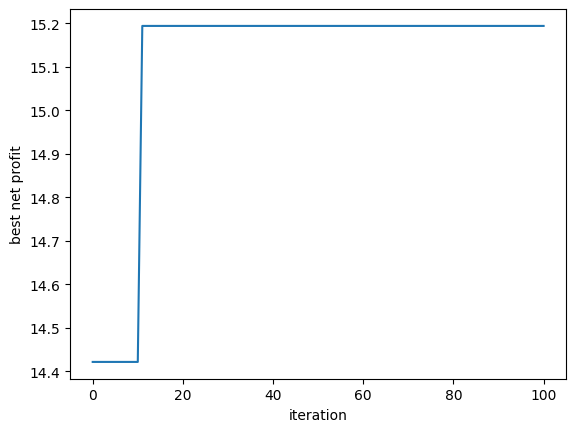

In [135]:
plt.plot(np.arange(len(history)),history)
plt.xlabel("iteration")
plt.ylabel("best net profit")